In [366]:
import copy
import pandas as pd
import numpy as np
import json


import datetime as dt
import random
import time

import math
import bisect
import itertools

#import statsmodels.api as sm

from IPython.display import clear_output


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from graphviz import Digraph
from scipy.ndimage import shift
#import pydot


from getpass import getpass
import os

import TransEntropy_mod as te
import k2_alg as k2

In [184]:
from scikit_alarm_framework.alarm_generator import set_point 

In [ ]:
os.environ['GITHUB_AUTH'] = getpass('GitHub user') + ':' + getpass('GitHub password')

!pip -q install -e git+https://${GITHUB_AUTH}@github.com/abugim/scikit-alarm-framework.git@develop#egg=scikit-alarm-framework

os.environ.pop('GITHUB_AUTH')


In [186]:
# https://pypi.python.org/pypi/pydot
!pip install graphviz

In [187]:
threshold_path = 'dist6_3horas_sig/threshold.csv'

In [188]:
def get_lim_index(cdf, lim):
    summation = 0
    index = 0
    for i in np.arange(0, cdf.size):
        if cdf[i] > lim:
            index = i
            break
    return index 

In [189]:
def surrogate(a):
    a_diff = np.diff(a)
    begin = np.where(a_diff > 0)[0]
    end = np.where(a_diff < 0)[0]
    
    if begin.size > end.size:
        end = np.append(end, a.size)
    elif begin.size < end.size:
        begin = np.insert(begin, 0, 0) 
    elif begin.size == 0 and end.size == 0:
        return a.copy()
    elif np.all(begin > end):
        begin = np.insert(begin, 0, 0)
        end = np.append(end, a.size)
    
    n_seq = np.max([begin.size, end.size])
    a_surr = np.zeros(a.shape)
    p_seq = np.random.randint(0, a.size - max(end - begin), size=n_seq)
    for i in np.random.permutation(n_seq):
        len_seq = end[i] - begin[i]
        a_surr[p_seq[i]:p_seq[i] + len_seq] = a[begin[i]:end[i]]
    return a_surr

In [190]:
#Method using stats model kde to return transfer etnropy value limit. That is, the 'x' value corresponding to P95
def significance_test(k,l,h,sup_lim, n, a,b):
    '''
        significance_test(a,b,k,l,h,sup_lim, n)
    '''
    transferEntropies = []    
    
    np.random.seed(int(time.time()))
    for i in np.arange(0,n):
        surrogate_a = surrogate(a.copy())
        transferEntropies.append(te(k,l,h,surrogate_a[:],b, 'serie_a', 'serie_b'))
        
    kde = sm.nonparametric.KDEUnivariate(transferEntropies)
    kde.fit()
    
    
    lvl_sig = kde.icdf[get_lim_index(kde.cdf, sup_lim)]
    return lvl_sig

In [191]:
##for paper test
def joint_probability_new(k,l,h, a, b, lbl_a, lbl_b):
    '''
        k B time horizon
        l A time horizon
        h instant in the future of serie B
        
        
        a, b array type'''
    
    numStates=2**(k+l+1)
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    prob_cnjt = np.zeros(numStates)
    
    #Alarm Series A (cause), B (effect), same len
    #teste   

    matrix_nova = np.matrix([b[1:],b[:-1],a[:-1]]).T
    df = pd.DataFrame(matrix_nova, columns = ['b_ftr', lbl_b, lbl_a])
    gpd = df.groupby(['b_ftr', lbl_b, lbl_a], as_index=False).size().reset_index(name='Count')
    total = sum(gpd['Count'])
    
    for i in np.arange(0,gpd.shape[0]):
        comb = [e for e in gpd.iloc[i][0:3].values.tolist()]
        idx = combinations.index(comb)
        prob_cnjt[idx] = gpd.iloc[i]['Count']/total

    return prob_cnjt

In [8]:
def joint_probability(k,l, h, a, b):
    '''
        k B time horizon
        l A time horizon
        h instant in the future of serie B
        
        a, b array type'''

    #Alarm Series A (cause), B (effect), same len
    #tested
    sizeSeries = a.size
    transEntropy = 0
    numStates = 2**(k + l  + 1)
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    counting = np.zeros(numStates)
    prob_cnjt = np.zeros(numStates)
    a_prob_ind = []
    b_prob_ind = []
    #joitn probability p(i_sub_t+1), i_sub_t**k, j_sub_t**l)
    inicio = np.max([k,l]) - 1
    for i in np.arange(inicio, sizeSeries - h):
        for hk in np.arange(0,k):
                b_prob_ind.append(b[i - hk])
        for hl in np.arange(0,l):
                a_prob_ind.append(a[i - hl])

        #print(a.size, b.size, a.size -1)     
        ab = [b[i + h]] + b_prob_ind + a_prob_ind 
        index_comb = combinations.index(ab)
        counting[index_comb] = counting[index_comb] + 1

        a_prob_ind = []
        b_prob_ind = []

    total = sum(counting)
  
    prob_cnjt = counting/total
     
    return prob_cnjt

In [192]:
#Joint probability evaluation p(i_t+h, i_t**k)
#tested
def joint_prob_ih_ik(k,l, joint_prob_ih_ik_jl):
    states_ith_ik = list(map(list, itertools.product([0, 1], repeat=k + 1)))
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1))) 
    p_jnt_ith_ik = np.zeros(2**(k+1))
    
    for i, state in enumerate(states_ith_ik):
        for j, comb in enumerate(combinations):
            if comb[0:k+1] == state:
                p_jnt_ith_ik[i] = p_jnt_ith_ik[i] + joint_prob_ih_ik_jl[j]
    return p_jnt_ith_ik

In [193]:
def conditional_prob(k,l,joint_prob):
    states = list(map(list, itertools.product([0, 1], repeat=k+l)))
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))

    size = int(joint_prob.size/2)
    conditional = np.zeros(2**(k+l+1))

    for i,state in enumerate(states):
        index_zero = combinations.index([0] + state)
        prob_zero = joint_prob[index_zero]

        index_one = combinations.index([1] + state)
        prob_one = joint_prob[index_one]

        if(prob_zero + prob_one != 0):
            conditional[i] = prob_zero/(prob_zero+ prob_one)
            conditional[i + 2**(k+l)] = prob_one/(prob_zero+ prob_one)
    return conditional

In [194]:
#Division of the conditionals in log2 
#tested
def conditional_div(k,l,conditional_num, conditional_den):
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    conditional_division = np.zeros(conditional_num.size)
    states_den = list(map(list, itertools.product([0, 1], repeat=1+k)))
    for j, comb in enumerate(combinations):
        if(conditional_den[states_den.index(comb[0:k+1])] != 0):
            conditional_division[j] = conditional_num[j]/conditional_den[states_den.index(comb[0:k+1])]            
    return conditional_division

In [197]:
#Transfer entropy final evaluation
def te(k,l,h_window, a,b):
    '''
        transentropy a->b
        te(k,l,h,a,b)
        k - dimension of b
        l - dimension of a
        h -> instant in the future of a
    '''
    #joint_p_ih_ik_jl = joint_probability_new(k,l,h,a,b, lbl_a, lbl_b)
    
    te_by_h = []
    for h in np.arange(1,h_window):
      joint_p_ih_ik_jl = joint_probability(k,l,h,a,b)

      joint_p_ih_ik = joint_prob_ih_ik(k,l, joint_p_ih_ik_jl)
      conditional_num = conditional_prob(k,l,joint_p_ih_ik_jl)
      conditional_den = conditional_prob(k,0, joint_p_ih_ik)    
      div = conditional_div(k,l,conditional_num, conditional_den)

      #log2 from the division of the conditionals -> #p(i_sub_t+h|i_sub_t**k, j_sub_t**l) /p(i_sub_t+h|i_t**k)
      log2_div_cond = np.log2(div[div!=0])
      te = np.sum(joint_p_ih_ik_jl[div!=0]*log2_div_cond)
      
      te_by_h.append(te)
      lag = np.argmax(te_by_h) + 1
    return [max(te_by_h), lag]

In [338]:
def transferEntropy_case(dist_df, h, k, l):
    start = time.process_time()
    transEntropy = np.zeros([dist_df.columns.size,dist_df.columns.size])
    lagEntropy = np.zeros([dist_df.columns.size,dist_df.columns.size])
    sigValues =  np.zeros([dist_df.columns.size,dist_df.columns.size])
    for i in np.arange(0, dist_df.columns.size):
        for j in np.arange(0, dist_df.columns.size):
            print('trans ', dist_df.columns[i], dist_df.columns[j])
            if(j != i + dist_df.columns.size/2 and j!=i and j != i - dist_df.columns.size/2):
                te_result = te(k,l,h, dist_df[dist_df.columns[i]], dist_df[dist_df.columns[j]])
                transEntropy[i][j] = te_result[0]
                lagEntropy[i][j] = te_result[1]
                
            clear_output()
    end = time.process_time()   
    
    print(end - start)
    return [transEntropy, lagEntropy]  

In [14]:
def apply_roll_mean(df, window):
    roll  = df.copy().rolling(window).mean() 
    roll.dropna(inplace=True)
    roll = roll.round(decimals=0).copy()
    roll.reset_index(drop=True, inplace=True)
    return roll

In [414]:
def graph_simple(df, eng = 'dot', lbl=False, size='3,3'):
    edge_style = ""
    g = Digraph(engine=eng)
    
    g = Digraph(engine=eng)
    g.attr(ratio='fill', size= size, margin='0')
    
    in_graph = []
    for k, row in enumerate(df.index):
        if any(df.loc[row]):
            g.node(str(row),row, shape='oval', fontsize='10', width='0', style='filled', fillcolor='white', color="black")
            in_graph.append(row)

              
    for c, col in enumerate(df.columns):
        if any(df[col]):
            if col not in in_graph:
                g.node(str(col), col, shape='oval', fontsize='10', width='0', style='filled', fillcolor='white', color="black") 

    for j, col in enumerate(df.columns):
        for i, row in enumerate(df.index):
            if(df[col][i]):
                if lbl:
                    label=str(df.at[row,col])
                else:
                    label = ''
                g.edge(str(row), str(col), label=label, style= edge_style, color='black')  
    return g 

In [386]:
def graph(df, df_lag, eng = 'dot'):
    edge_style = ""
    g = Digraph(engine=eng)
    g.attr(ratio='fill', size='3,3')
   
    for k, row in enumerate(df.index):
        if any(df.iloc[k]) or any(df[row]):
            g.node(str(k),row, shape='oval', fontsize='10', width='0', style='filled', fillcolor='#c9c9c9', color="white") 

    for j, col in enumerate(df.columns):
        for i, row in enumerate(df[col]):
            if(row):
                te_val  = str(np.round(row, 6))
                g.edge(str(i), str(j), label=str(df_lag[df_lag.columns[j]][i]),style= edge_style, color='black')  
    return g 

In [387]:
def graph_from_dict(dictionary, eng = 'dot'):
    edge_style = ""
    g = Digraph(engine=eng)
    g.attr(ratio='fill', size='3,3')
   
    for k, i in dictionary.items():
        g.node(str(k),k, shape='oval', fontsize='10', width='0', style='filled', fillcolor='#c9c9c9', color="gray") 
        df_te.m
    for k, i in dictionary.items():
        for it in i:
            g.edge(str(it), str(k), label='',style= edge_style, color='dark')  
    return g 

In [199]:
def generate_df_valid_corrs(df, limit):
    df_valid = df.copy()
    for row in df.columns:
        for col in df.columns:
            if df[row][col] < limit:
                df_valid[row][col] = 0
                
    return df_valid 

In [200]:
def generate_df_max_info(df):
    df_max_info = pd.DataFrame(data = np.zeros([len(df),len(df)]),columns=df.columns, index = df.columns)
    for  i,col in enumerate(df.columns):
        sort = df[col].sort_values(ascending=False)
        df_max_info.loc[sort.index[0]][i] = sort[0]
    return df_max_info
    

In [201]:
def apply_first_diff(df):
    dist_diff = df.diff()
    dist_diff.clip(lower=0, inplace=True)
    dist_diff.dropna(inplace=True)
    dist_diff.reset_index(drop=True, inplace=True)
    dist_diff = dist_diff.astype(int)
    
    return dist_diff

In [202]:
def rm_smtc_cicle(df):
    rm_df = df.copy()
    for c, col in enumerate(rm_df.columns):
        for r, row in enumerate(rm_df[col]):
            simetric_val = rm_df[rm_df.columns[r]][c]
            if row and simetric_val:
                if simetric_val >= row:
                    rm_df[col][r] = 0
                else:
                    simetric_val = 0
    return rm_df
                

In [203]:
def get_ancestrals(lista, node, lista_nova):
    if np.all(np.unique(lista[node]) == ['x']):
        return lista_nova
    
    if not node in lista_nova:
        lista_nova.extend([node])
            
    if not lista[node]:
        return lista_nova
    else:
        for i,no in enumerate(lista[node]):       
            idx = no
            node_to_list = [lista[node][i]]
            lista[node][i] = 'x'
            if no == 'x':
                continue
            if 'x' in lista[no]:
                get_ancestrals(lista, idx, lista_nova)   
            elif not lista[no]:
                lista_nova.extend(node_to_list)
                lista[no] = ['x']
                continue
            else:
                lista_nova.extend(node_to_list)
                get_ancestrals(lista, idx, lista_nova)             
        else:
            return get_ancestrals(lista, node, lista_nova)

In [204]:
def generate_aciclic_graph(grafo_param):
    graph_mat = copy.deepcopy(grafo_param)
    grafo_ac = np.zeros([len(graph_mat), len(graph_mat)], dtype=float)
    ancestrals = [[] for el in np.arange(0, len(graph_mat))]
    
    max_val = max(graph_mat.flatten().tolist())
    print(max_val)
    idx_max = np.argmax(graph_mat.flatten().tolist())  

    while(max_val > 0):
        idx_row = int(np.floor(idx_max)/len(graph_mat))
        idx_col = idx_max - len(graph_mat)*idx_row

        impossible_nodes = []
        if ancestrals[idx_row]:
            impossible_nodes = get_ancestrals(copy.deepcopy(ancestrals),idx_row, [])
            if not idx_col in impossible_nodes:
                grafo_ac[idx_row, idx_col] = graph_mat[idx_row, idx_col]
                ancestrals[idx_col] += [idx_row] 
        else:
            ancestrals[idx_col] += [idx_row]
            grafo_ac[idx_row,idx_col] = max_val

        graph_mat[idx_row, idx_col] = 0
        max_val = max(graph_mat.flatten().tolist())
        idx_max = np.argmax(graph_mat.flatten())
    return grafo_ac

In [205]:
def get_lags_ances(mat, idx, soma, lista_lags, ref):
    
    if np.all(mat[:,idx] == np.zeros(len(mat))):
        mat[idx] =  [-1 for peso in mat[idx]]
        return 0

    for i,dad_lag in enumerate(mat[:,idx]):
        if dad_lag != 0:
            if not np.all(mat[i] == [-1 for peso in mat[i]]):
                soma += dad_lag
                lista_lags.append((str(i), soma))
                get_lags_ances(mat, i, soma, lista_lags, ref)
                
                soma = 0

           
    return lista_lags
        
        
    

In [206]:
def get_lags_ances_df(mat,idx, soma, dict_lags, lista, dict_caminhos):
    lista.append(idx)
    if np.all(mat[idx] == np.zeros(len(mat))):
        return [dict_lags,dict_caminhos]
    for i,dad_lag in enumerate(mat[idx]):
        if dad_lag > 0:
          
            soma += dad_lag
            try:
                dict_lags[mat.columns[i]].append(soma)
                dict_caminhos[mat.columns[i]].append(lista)
            except:
                dict_lags[mat.columns[i]] = [soma]
                dict_caminhos[mat.columns[i]]= [lista]
        
            get_lags_ances_df(mat, mat.columns[i], soma, dict_lags, lista[:], dict_caminhos)
            soma -= dad_lag
            
    return [dict_lags, dict_caminhos] 

In [207]:
def get_all_shifts(nodes, mat):
    dic = {}
    for node in nodes:
        mat_cp = mat.copy()
#         if not np.all(mat_cp[node] == np.zeros(len(mat_cp))):
        dic[node] = get_lags_ances_df(mat_cp, node, 0, {}, [],{})[0]
    return dic

In [208]:

def gen_tree_from_lags(dici):
    tree_k2 = {}
    for key_son, value in dici.items():    
        if value:
            for key_dad, value_dad in value.items():
                for i, value in enumerate(value_dad):
                    try:
                        tree_k2[key_son].append(key_dad+"-"+str(i)+"_"+str(int(value)))
                    except:
                        tree_k2[key_son] = [key_dad+"-"+str(i)+"_"+str(int(value))]
                            
                    tree_k2[key_dad+"-"+str(i)+"_"+str(int(value))] = []
        else:
            tree_k2[key_son] = []
    return tree_k2  
        


In [209]:
def gen_df_iteration(df, node, dict_lag):
    df_gen = df.copy()
    if dict_lag[node]:
        for key_dad, values_dad in dict_lag[node].items():
            for i, val in enumerate(dict_lag[node][key_dad]): 
                df_gen[key_dad+"-"+str(i)+"_"+str(int(val))] = shift(df_gen[key_dad], int(val), order=0, mode='constant', cval=np.NaN)
    df_gen.dropna(inplace=True)
    return df_gen


In [210]:
proc_path = 'proc_i3e.csv'

proc_df = pd.read_csv(proc_path, index_col='TOUT', usecols=['TOUT']+["XMEAS%02d" % x for x in  [1,2,3,6,7,8,9,21]])
proc_df.index = pd.to_datetime(proc_df.index, unit='s')
proc_df.head()

,XMEAS01,XMEAS02,XMEAS03,XMEAS06,XMEAS07,XMEAS08,XMEAS09,XMEAS21
TOUT,,,,,,,,
2019-12-10 16:54:17.616330147,0.271033,3649.739415,4451.320791,47.559754,2798.975799,64.995825,122.898796,102.480028
2019-12-10 16:54:53.616330147,0.270093,3663.351750,4428.605105,47.917222,2799.059838,65.254940,122.883398,102.484819
2019-12-10 16:55:29.616330147,0.271255,3656.090868,4429.093949,47.750928,2799.345791,64.930642,122.909663,102.499473
2019-12-10 16:56:05.616330147,0.269950,3664.897833,4439.129238,47.305023,2799.251300,65.188788,122.909316,102.465085
2019-12-10 16:56:41.616330147,0.270947,3616.540495,4446.078748,47.813862,2798.967112,65.686033,122.887484,102.463271


In [211]:
threshold_df = pd.read_csv(threshold_path, index_col='proc_var')
threshold_df = threshold_df.loc[[1,2,3,6,7,8,9,21]]
threshold_df

,limit,type,dead_band,delay_time
proc_var,,,,
1,0.249111,LOW,NaN,NaN
1,0.284437,HIGH,NaN,NaN
2,3597.394823,LOW,NaN,NaN
2,3711.109968,HIGH,NaN,NaN
3,4371.271459,LOW,NaN,NaN
3,4514.069121,HIGH,NaN,NaN
6,46.954535,LOW,NaN,NaN
6,48.235269,HIGH,NaN,NaN
7,2796.971605,LOW,NaN,NaN


In [212]:
thresh_low = threshold_df[threshold_df['type'] == 'LOW']['limit'].values
thresh_high = threshold_df[threshold_df['type'] == 'HIGH']['limit'].values

In [213]:
high_alarms = set_point.generate(proc_df, thresh_high)
low_alarms = set_point.generate(proc_df, thresh_low)

In [214]:
new_high_names = [ col.replace('MEAS', '').lower() +'_high' for col in (proc_df.columns)]
new_low_names = [col.replace('MEAS', '').lower() + '_low' for col in (proc_df.columns)]

rename_high = {key:value for key, value in zip(high_alarms.columns,new_high_names)}
rename_low = {key:value for key, value in zip(low_alarms.columns,new_low_names)}

high_alarms = high_alarms.rename(rename_high, axis='columns')
low_alarms = low_alarms.rename(rename_low, axis='columns')

alarms_df = pd.concat([high_alarms, low_alarms], axis=1)

In [215]:
alarms_df

,x01_high,x02_high,x03_high,x06_high,x07_high,x08_high,x09_high,x21_high,x01_low,x02_low,x03_low,x06_low,x07_low,x08_low,x09_low,x21_low
TOUT,,,,,,,,,,,,,,,,
2019-12-10 16:54:17.616330147,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
2019-12-10 16:54:53.616330147,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
2019-12-10 16:55:29.616330147,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
2019-12-10 16:56:05.616330147,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
2019-12-10 16:56:41.616330147,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-11 08:51:53.616330147,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
2020-01-11 08:52:29.616330147,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
2020-01-11 08:53:05.616330147,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1


In [216]:
#applying 5 samples mooving mean
df_alm_mean5 = apply_roll_mean(alarms_df, 5)
df_alm_mean5.to_csv("resultados_defesa/alm_seq_m5.csv")

In [96]:
#Computation of TE - 
# df_te = transferEntropy_case(df_alm_mean5, 50,1,1)


In [122]:
#Creation of the dataframes of TE and TE lags

# te_data = pd.DataFrame(df_te[0], columns = cols, index= cols)
# df_te_lag = pd.DataFrame(df_te[1], columns = cols, index= cols)


In [124]:
#Saving of TE an lags TE
# te_data.to_csv("resultados_defesa/df_te_i3eA.csv")
# df_te_lag.to_csv("resultados_defesa/df_te_lag_i3eA.csv")


In [217]:
#Reading of already computed TE and lags

df_te = pd.read_csv("resultados_defesa/df_te_i3eA.csv", index_col=0)
df_te_lags = pd.read_csv("resultados_defesa/df_te_lag_i3eA.csv", index_col=0)



In [68]:
# cols = [col.replace("MEAS", '').lower() + '_high' for col in proc_df.columns] + [col.replace("MEAS", '').lower() + '_low' for col in proc_df.columns] 

# rename_te = {key:value for key, value in zip(df_te.columns, cols)}

# #renaming of columns and resave 
# df_te.rename(rename_te, axis='columns', inplace=True)
# df_te_lags.rename(rename_te, axis='columns', inplace=True)

# df_te.index = cols
# df_te_lags.index = cols

# df_te.to_csv("resultados_defesa/df_te_i3eA.csv")
# df_te_lags.to_csv("resultados_defesa/df_te_lag_i3eA.csv")

In [218]:
df_te = pd.read_csv("resultados_defesa/df_te_i3eA.csv", index_col=0)
df_te_lags = pd.read_csv("resultados_defesa/df_te_lag_i3eA.csv", index_col=0)

In [289]:
df_te_lags

,x01_high,x02_high,x03_high,x06_high,x07_high,x08_high,x09_high,x21_high,x01_low,x02_low,x03_low,x06_low,x07_low,x08_low,x09_low,x21_low
x01_high,0.0,1.0,1.0,1.0,46.0,4.0,49.0,49.0,0.0,1.0,1.0,10.0,49.0,1.0,14.0,49.0
x02_high,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
x03_high,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
x06_high,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
x07_high,49.0,1.0,1.0,1.0,0.0,4.0,18.0,42.0,49.0,1.0,1.0,11.0,0.0,1.0,17.0,32.0
x08_high,49.0,1.0,1.0,1.0,19.0,0.0,13.0,45.0,13.0,1.0,1.0,20.0,49.0,0.0,24.0,23.0
x09_high,49.0,1.0,1.0,1.0,42.0,8.0,0.0,48.0,49.0,1.0,1.0,10.0,49.0,1.0,0.0,8.0
x21_high,49.0,1.0,1.0,1.0,49.0,37.0,49.0,0.0,49.0,1.0,1.0,31.0,29.0,1.0,49.0,0.0
x01_low,0.0,1.0,1.0,1.0,49.0,49.0,49.0,49.0,0.0,1.0,1.0,32.0,49.0,1.0,36.0,5.0
x02_low,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


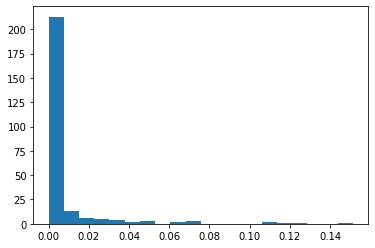

In [341]:
hist = plt.hist(df_te.values.flatten(),bins=20)

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['axes.linewidth'] = 0.3
plt.rcParams['font.size'] = 5

plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['legend.borderpad'] = 0.2
plt.rcParams['legend.frameon']= True
plt.rcParams['legend.borderpad']= 0.1

plt.show()

plt.gcf().savefig("process_var.pdf", bbox_inches='tight')

In [ ]:
plt.rcParams

In [367]:
#finding the threshold using the left limit from the second bar in histogram

sort_tes = list(np.sort(df_te.values.flatten()))

idx = bisect.bisect_left(sort_tes,hist[1][1])

# idx = np.round(len(df_te.values.flatten())*0.83)
t = sort_tes[int(idx)]
print(t)
percentile = idx/len(sort_tes)
print(percentile)

0.007668474476869511
0.83203125


In [313]:
plt.hist?

In [336]:

idx_ = sort.index(0.00756392)

sort[int(idx)]

ValueError: 0.00756392 is not in list

In [432]:
g_te  = graph_simple(df_te, eng="circo",size='3,3')
g_te.render('resultados_defesa/teSemThresh1', view=True, )  

'resultados_defesa/teSemThresh1.pdf'

In [ ]:
t_roc = 0.01816308533330481
t_roc2 = 0.055674922579944816
df_ltd = generate_df_valid_corrs(df_te, t_roc)
df_ltd

In [357]:

df_graph_ltd = generate_df_valid_corrs(df_te, t)
mat_graph_ltd_ac = generate_aciclic_graph(df_graph_ltd.values)

df_te_i3eA_ac = pd.DataFrame(data= mat_graph_ltd_ac, columns= df_graph_ltd.columns, index = df_graph_ltd.columns)
df_te_i3eA_ac.to_csv('resultados_defesa/te_i3eA_ac.csv')

0.1512784756129776


/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [427]:
g_ltd = graph_simple(df_graph_ltd, eng='circo', size='3,3')
g_ltd.render('resultados_defesa/teThresh1', view=True)  

'resultados_defesa/teThresh1.pdf'

In [389]:
df_lags_final  = df_te_lags[df_te_i3eA_ac > 0].fillna(0)
df_lags_final.to_csv('resultados_defesa/df_lags_i3eA_final.csv')



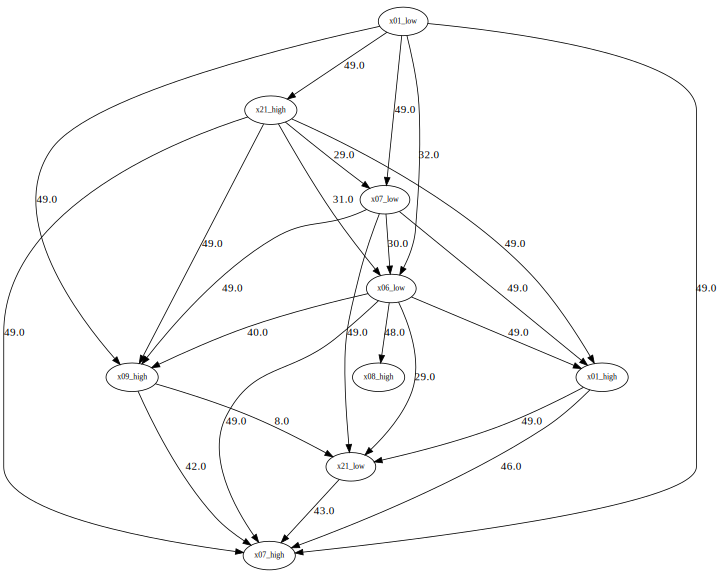

In [437]:
g_bef = graph_simple(df_lags_final, eng='dot',size='10,10', lbl=True)
# g_bef.render('resultados_defesa/beforeK21', view=False) 
g_bef

In [433]:
k2_result

{'x01_high': ['x21_high-2_108', 'x07_low-0_79', 'x21_high-3_78'],
 'x02_high': [],
 'x03_high': [],
 'x06_high': [],
 'x07_high': ['x09_high-0_42',
  'x06_low-2_49',
  'x21_high-2_154',
  'x21_high-17_150',
  'x21_high-11_141',
  'x21_high-18_129'],
 'x08_high': ['x21_high-0_79', 'x07_low-0_78', 'x21_high-1_107'],
 'x09_high': ['x21_high-0_49', 'x07_low-1_49', 'x01_low-6_127'],
 'x21_high': [],
 'x01_low': [],
 'x02_low': [],
 'x03_low': [],
 'x06_low': ['x21_high-0_31'],
 'x07_low': ['x21_high-0_29'],
 'x08_low': [],
 'x09_low': [],
 'x21_low': ['x09_high-0_8']}

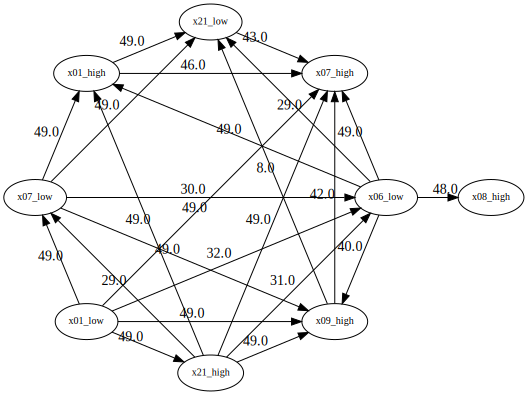

In [365]:
graph_simple(df_lags_final, eng='circo', lbl=True)

In [362]:
dict_all_lags = get_all_shifts(df_lags_final.columns, df_lags_final.copy())
k2_te_tree = te.gen_tree_from_lags(dict_all_lags)

In [363]:
 k2_te_tree

{'x01_high': ['x21_high-0_49',
  'x21_high-1_80',
  'x21_high-2_108',
  'x21_high-3_78',
  'x01_low-0_98',
  'x01_low-1_129',
  'x01_low-2_81',
  'x01_low-3_157',
  'x01_low-4_128',
  'x01_low-5_127',
  'x01_low-6_98',
  'x06_low-0_49',
  'x07_low-0_79',
  'x07_low-1_49'],
 'x21_high-0_49': [],
 'x21_high-1_80': [],
 'x21_high-2_108': [],
 'x21_high-3_78': [],
 'x01_low-0_98': [],
 'x01_low-1_129': [],
 'x01_low-2_81': [],
 'x01_low-3_157': [],
 'x01_low-4_128': [],
 'x01_low-5_127': [],
 'x01_low-6_98': [],
 'x06_low-0_49': [],
 'x07_low-0_79': [],
 'x07_low-1_49': [],
 'x02_high': [],
 'x03_high': [],
 'x06_high': [],
 'x07_high': ['x01_high-0_46',
  'x01_high-1_92',
  'x21_high-0_95',
  'x21_high-1_126',
  'x21_high-2_154',
  'x21_high-3_124',
  'x21_high-4_91',
  'x21_high-5_113',
  'x21_high-6_141',
  'x21_high-7_120',
  'x21_high-8_49',
  'x21_high-9_80',
  'x21_high-10_108',
  'x21_high-11_141',
  'x21_high-12_172',
  'x21_high-13_200',
  'x21_high-14_170',
  'x21_high-15_100',


In [378]:
import cProfile
import re



In [444]:
k2_result_05 = k2.k2(df_alm_mean5, k2_te_tree, df_lags_final, 0.5)

KeyboardInterrupt: 

In [443]:
k2_result05

NameError: name 'k2_result05' is not defined

In [370]:
#k2 save
with open ('k2_result_2.txt', 'w') as file:
    file.write(json.dumps(k2_result))

here  x21_high x01_high
here  x21_high x01_high
here  x07_low x01_high
here  x21_high x01_high
here  x09_high x07_high
here  x06_low x07_high
here  x21_high x07_high
here  x21_high x07_high
here  x21_high x07_high
here  x21_high x07_high
here  x21_high x07_high
here  x21_high x07_high
here  x21_high x07_high
here  x21_high x07_high
here  x21_high x07_high
here  x21_high x07_high
here  x21_high x07_high
here  x21_high x07_high
here  x21_high x08_high
here  x07_low x08_high
here  x21_high x08_high
here  x21_high x08_high
here  x21_high x09_high
here  x07_low x09_high
here  x01_low x09_high
here  x01_low x09_high
here  x21_high x06_low
here  x21_high x07_low
here  x09_high x21_low


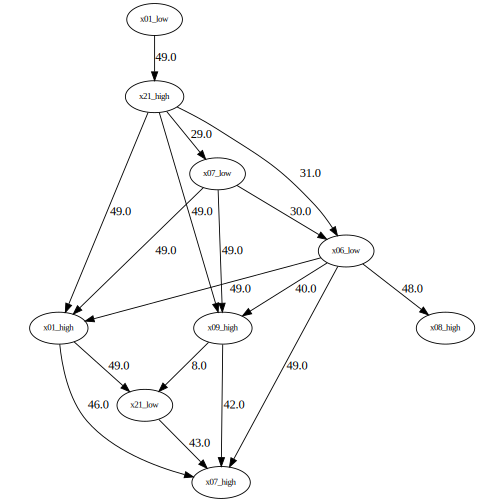

In [441]:
clean_df = k2.gen_clean_df(df_lags_final, k2_result)
df_path  = df_lags_final[clean_df>0].fillna(0)

graph_simple(df_path, eng='dot', size='7,7',lbl=True)

In [ ]:
##transformar em função

lista_9 = get_lags_ances_df(df_lags_final, 'xmeas01_high',0, {}, [], {})[1]

df_clean = pd.DataFrame(data=np.zeros([len(df_lags_final.columns),len(df_lags_final.columns)], dtype=float), columns= df_lags_final.columns, index= df_lags_final.columns) 


count = 0
node_ref = 'xmeas09_high'
idx_ref = 0
node_son = 'xmeas01_high'

path_list = lista_9[node_ref][idx_ref][::-1]
while count < len(lista_9[node_ref][idx_ref][::-1]) -1:

    if len(lista_9[node_ref][idx_ref][::-1]) == 1:
        df_clean.at[node_ref,node_son] = 1
    else:
        df_clean.at[path_list[count], path_list[count+1]] = 1
    count +=1
     
df_clean.at[node_ref, path_list[0]] = 1
    
    